In [41]:
import pandas as pd
import matplotlib.pyplot as plt
from operator import methodcaller
import sys
sys.path.append("../..")
from ai4material_design.scripts.summary_table_lean import read_trial
from ai4material_design.ai4mat.data.data import StorageResolver

In [42]:
targets = ["formation_energy_per_site"]
results = []
with open("../scripts/ASPIRE-1/vacancy_pairs.txt", "rt") as definitions_file:
    for line in definitions_file:
        trial, target, n_repeats, _, experiment = line.strip().split()
        for i in range(1, int(n_repeats) + 1):
            these_results = read_trial(experiment, f"stability/{trial}/{i}", True, targets, True)
            these_results["trial_family"] = trial
            these_results["trial_index"] = i
            results.append(these_results)

high_to_V2_trial = "megnet_pytorch/sparse/d6b7ce45_no_resample"
these_results = read_trial("vacancy_pairs_GaSe", high_to_V2_trial, True, ["formation_energy_per_site"], True)
these_results["experiment"] = "vacancy_pairs"
these_results["trial_family"] = "high_to_V2"
these_results["trial_index"] = 1
results.append(these_results)

In [43]:
results_pd = pd.concat(results, axis=0).sort_index()

In [44]:
results_pd

mae  \
target                    dataset           trial                                                          
formation_energy_per_site combined          megnet_pytorch/sparse/d6b7ce45_no_resample          0.159984   
                                            stability/catboost/29-11-2022_13-16-01/02e5eda9/1   0.225738   
                                            stability/catboost/29-11-2022_13-16-01/02e5eda9/10  0.396508   
                                            stability/catboost/29-11-2022_13-16-01/02e5eda9/11  0.729270   
                                            stability/catboost/29-11-2022_13-16-01/02e5eda9/12  0.458599   
...                                                                                                  ...   
                          vacancy_pairs/hBN stability/schnet/25-11-2022_16-52-31/71debf15/5     0.424730   
                                            stability/schnet/25-11-2022_16-52-31/71debf15/6     0.784678   
                                            stability/schnet/25-11-2022_16-52-31/71debf15/7     1.212541   
                                            stability/schnet/25-11-2022_16-52-31/71debf15/8     0.469754   
                                            stability/schnet/25-11-2022_16-52-31/71debf15/9     0.652299   

                                                                                                     std  \
target                    dataset           trial                                                          
formation_energy_per_site combined          megnet_pytorch/sparse/d6b7ce45_no_resample          0.248490   
                                            stability/catboost/29-11-2022_13-16-01/02e5eda9/1   0.306430   
                                            stability/catboost/29-11-2022_13-16-01/02e5eda9/10  0.476005   
                                            stability/catboost/29-11-2022_13-16-01/02e5eda9/11  0.935934   
                                            stability/catboost/29-11-2022_13-16-01/02e5eda9/12  0.480777   
...                                                                                                  ...   
                          vacancy_pairs/hBN stability/schnet/25-11-2022_16-52-31/71debf15/5     0.639198   
                                            stability/schnet/25-11-2022_16-52-31/71debf15/6     0.803845   
                                            stability/schnet/25-11-2022_16-52-31/71debf15/7     0.917914   
                                            stability/schnet/25-11-2022_16-52-31/71debf15/8     0.880056   
                                            stability/schnet/25-11-2022_16-52-31/71debf15/9     0.613706   

                                                                                                                                           errors  \
target                    dataset           trial                                                                                                   
formation_energy_per_site combined          megnet_pytorch/sparse/d6b7ce45_no_resample          _id
GaSe_Ga71Se71_6f0b416e-437a-4115-a4c4-cd03...   
                                            stability/catboost/29-11-2022_13-16-01/02e5eda9/1   _id
GaSe_Ga71Se71_6f0b416e-437a-4115-a4c4-cd03...   
                                            stability/catboost/29-11-2022_13-16-01/02e5eda9/10  _id
GaSe_Ga71Se71_6f0b416e-437a-4115-a4c4-cd03...   
                                            stability/catboost/29-11-2022_13-16-01/02e5eda9/11  _id
GaSe_Ga71Se71_6f0b416e-437a-4115-a4c4-cd03...   
                                            stability/catboost/29-11-2022_13-16-01/02e5eda9/12  _id
GaSe_Ga71Se71_6f0b416e-437a-4115-a4c4-cd03...   
...                                                                                                                                           ...   
                          vacancy_pairs/hBN stability/schnet/25-11-2022_16-52-31/71debf15/5     [2.

In [45]:
labels = {
    "schnet/25-11-2022_16-52-31/71debf15": "SchNet, tuned",
    "schnet/base": "SchNet, default",
    "catboost/29-11-2022_13-16-01/02e5eda9": "CatBoost, tuned",
    "catboost/base": "CatBoost, default",
    'gemnet/16-11-2022_20-05-04/b5723f85': "GemNet, tuned",
    "gemnet/base": "GemNet, default",
    "megnet_pytorch/25-11-2022_11-38-18/1baefba7": "MegNet (full), tuned",
    'megnet_pytorch/full/base': "MegNet (full), default",
    "megnet_pytorch/sparse/d6b7ce45_no_resample": "MegNet (sparse), tuned",
    "high_to_V2": "Tuned MegNet (sparse),\ntrained on high-density for this material only"
}

def plot_dataset(results_dataframe, material):
    dataset_name = f"vacancy_pairs/{material}"
    folded_predictions = results_pd.loc[
    ("formation_energy_per_site", dataset_name),
    ("trial_family", "trial_index", "predictions")].set_index(
        ["trial_family", "trial_index"]).squeeze()
    predictions_list = []
    for (trail_family, trial_index), these_predictions in folded_predictions.items():
        prediction_frame = these_predictions.to_frame()
        prediction_frame["trial_family"] = trail_family
        prediction_frame["trial_index"] = trial_index
        prediction_frame.set_index(["trial_family", "trial_index", prediction_frame.index], inplace=True)
        predictions_list.append(prediction_frame.squeeze())
    predictions_pd = pd.concat(predictions_list, axis=0)
    structures = pd.read_pickle(StorageResolver()["processed"]/dataset_name/"data.pickle.gz").reindex(
        predictions_pd.index.get_level_values('_id').unique())
    defect_counts = structures.defect_representation.apply(len)
    assert (defect_counts == 2).all()
    distances = structures.defect_representation.apply(methodcaller("get_distance", 0, 1))
    true_energies = structures.formation_energy_per_site
    distance_order = distances.argsort()
    fig, ax = plt.subplots(figsize=(9.5, 5))
    for trial_family, family_predictions in predictions_pd.groupby(level="trial_family"):
        prediction_mean = family_predictions.groupby(level="_id").mean()
        prediction_std = family_predictions.groupby(level="_id").std()
        ax.errorbar(distances, prediction_mean, yerr=prediction_std, label=labels[trial_family], fmt="*")
    ax.plot(distances[distance_order], true_energies[distance_order], label="DFT")
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, 0), ncol=4)
    ax.set_xlabel("Distance (Å)")
    ax.set_ylabel("Formation energy (eV/site)")
    ax.set_title(f"{material}")
    plt.tight_layout()
    fig.savefig(f"{material}.png", dpi=300)

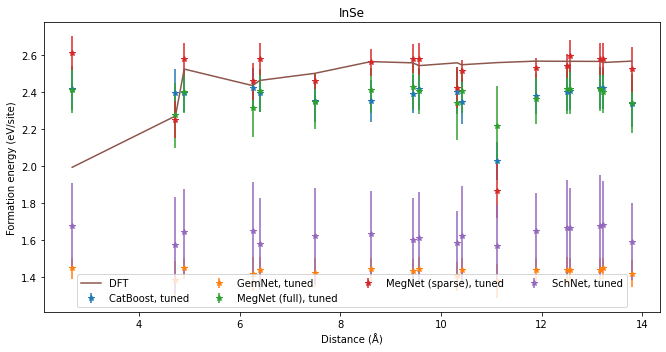

In [46]:
plot_dataset(results_pd, "InSe")

/home/users/nus/kna/.local/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/users/nus/kna/.local/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


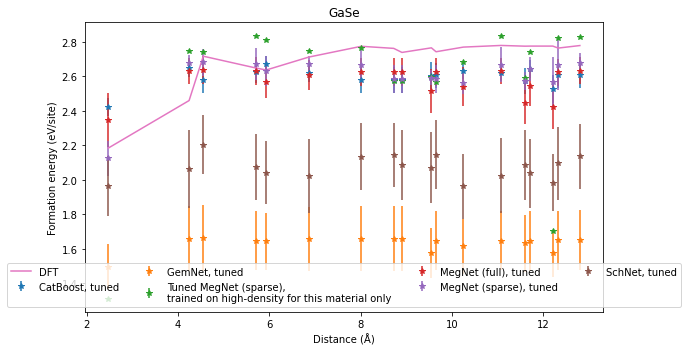

In [47]:
plot_dataset(results_pd, "GaSe")

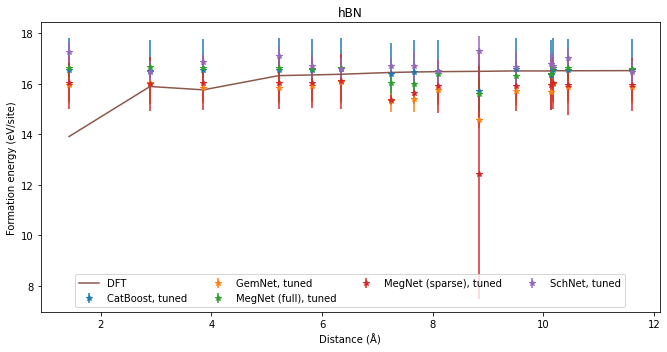

In [48]:
plot_dataset(results_pd, "hBN")